In [172]:
import inspect
import numpy as np
import matplotlib.pyplot as plt
# from andi_datasets.models_phenom import models_phenom
# import stochastic
# from andi_datasets.utils_trajectories import plot_trajs
from tsai.all import *
import sklearn.metrics as skm

from tqdm import tqdm
np.random.seed(7)

In [173]:
with open('trajs.csv', 'rb') as f:
    trajs = np.load(f)
    
with open('labels.csv', 'rb') as f:
    labels = np.load(f)
    
with open('trajs_test.csv', 'rb') as f:
    trajs_test = np.load(f)
    
with open('labels_test.csv', 'rb') as f:
    labels_test = np.load(f)

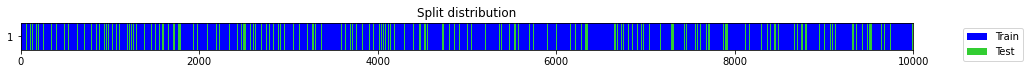

((#8000) [8084,8107,4548,196,6629,6003,8080,4736,3323,3588...],
 (#2000) [567,4643,6215,2218,4413,5181,7118,1791,4621,6663...])

In [174]:
splits = get_splits(labels, valid_size=.2, stratify=True, random_state=23, shuffle=True)
splits

In [175]:
tfms = [None, TSRegression()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(trajs, labels, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=128)


In [176]:
archs = [
    "GRU",
    "MLP",
    "FCN",
    "ResNet",
    "mWDN",
    "TCN",
    "InceptionTime",
    "XceptionTime",
    "ResCNN",
    "TST",
    "TSiT",
    "MiniRocket",
    "XCM",
    "gMLP",
    "TSSequencerPlus",
    "TransformerModel",
    "LSTMAttention",
    "GRUAttention",
    "RNN_FCN",
    "MLSTM_FCN",
    "MRNN_FCN",
    "GRU_FCN",
    "LSTM_FCN",
    "TSTPlus"]

  0%|          | 0/24 [00:00<?, ?it/s]

GRU


epoch,train_loss,valid_loss,_rmse,time
0,0.257966,0.244434,0.494402,00:00
1,0.232094,0.208982,0.457146,00:00
2,0.192136,0.151907,0.389753,00:00
3,0.126418,0.065731,0.256381,00:00
4,0.078675,0.057913,0.240652,00:00
5,0.063314,0.056324,0.237326,00:00
6,0.057672,0.055256,0.235065,00:00
7,0.055417,0.053735,0.231808,00:00
8,0.053854,0.053339,0.230952,00:00
9,0.052484,0.051352,0.226610,00:00


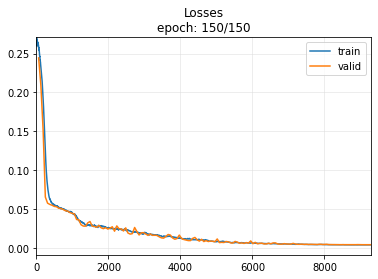

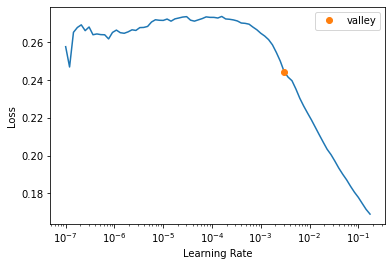

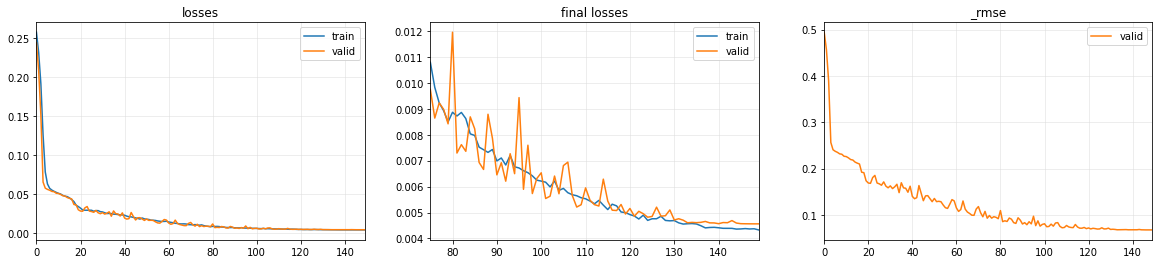

  4%|▍         | 1/24 [02:09<49:39, 129.55s/it]

MLP


epoch,train_loss,valid_loss,_rmse,time
0,0.093100,0.067215,0.259259,00:00
1,0.059692,0.055185,0.234916,00:00
2,0.050851,0.051666,0.227301,00:00
3,0.047652,0.050241,0.224144,00:00
4,0.045856,0.046331,0.215246,00:00
5,0.044218,0.047355,0.217612,00:00
6,0.043001,0.043662,0.208955,00:00
7,0.041931,0.043316,0.208124,00:00
8,0.040568,0.042062,0.205090,00:00
9,0.039658,0.044458,0.210850,00:00


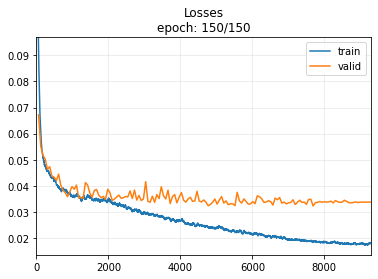

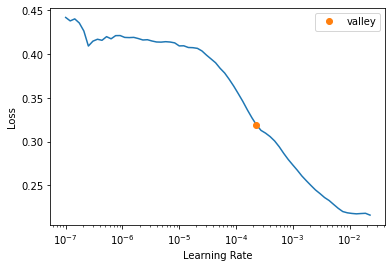

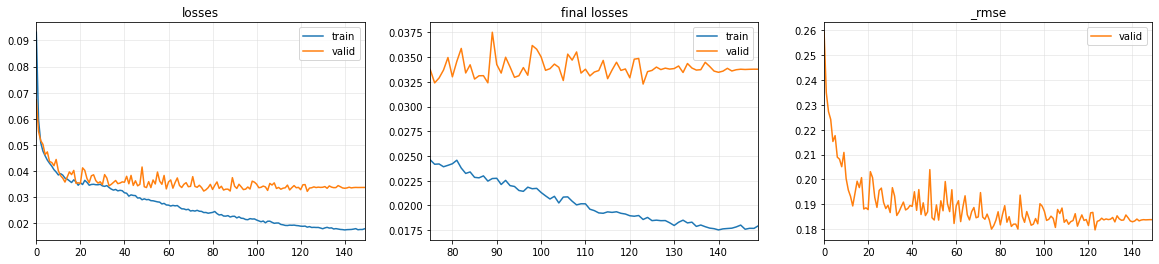

  8%|▊         | 2/24 [04:04<44:14, 120.67s/it]

FCN


epoch,train_loss,valid_loss,_rmse,time
0,0.035022,0.025984,0.161195,00:00
1,0.024153,0.018075,0.134444,00:00
2,0.018522,0.014936,0.122214,00:00
3,0.015743,0.014102,0.118753,00:00
4,0.013572,0.013105,0.114478,00:00
5,0.012076,0.011494,0.107210,00:00
6,0.011789,0.016437,0.128206,00:00
7,0.010361,0.008923,0.094462,00:00
8,0.009257,0.009138,0.095593,00:00
9,0.011617,0.032363,0.179898,00:00


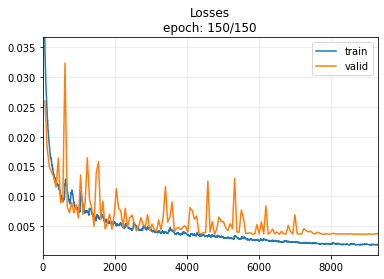

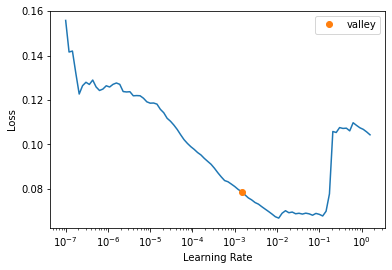

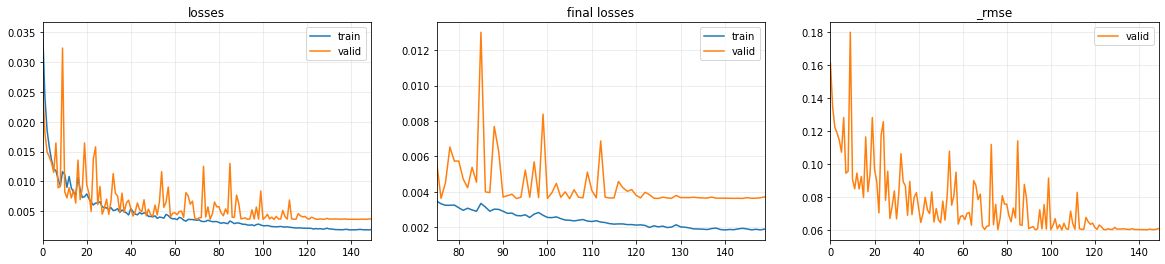

 12%|█▎        | 3/24 [06:46<48:52, 139.63s/it]

ResNet


epoch,train_loss,valid_loss,_rmse,time
0,0.032935,0.019996,0.141408,00:01
1,0.017708,0.011583,0.107625,00:01
2,0.012221,0.008956,0.094638,00:01
3,0.009278,0.007882,0.088778,00:01
4,0.007744,0.007680,0.087635,00:01
5,0.006618,0.007255,0.085178,00:01
6,0.006022,0.006196,0.078715,00:01
7,0.006448,0.007800,0.088317,00:01
8,0.005779,0.004902,0.070018,00:01
9,0.005011,0.006236,0.078968,00:01


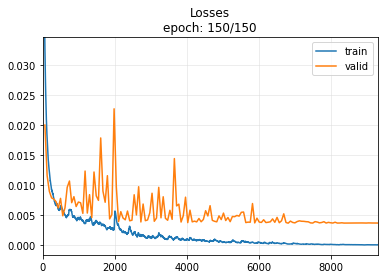

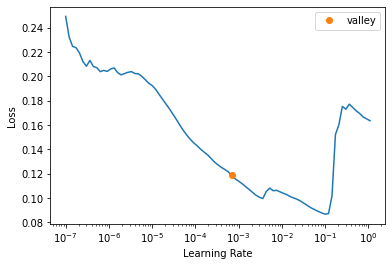

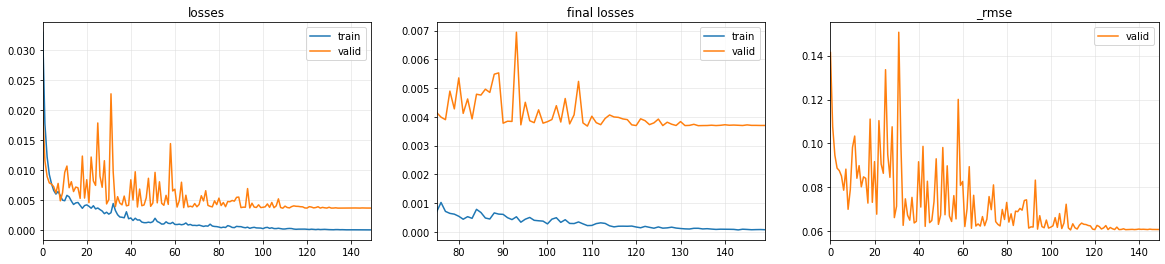

 17%|█▋        | 4/24 [11:06<1:02:24, 187.22s/it]

mWDN


epoch,train_loss,valid_loss,_rmse,time
0,0.033626,0.040157,0.200393,00:02
1,0.019027,0.012792,0.113101,00:02
2,0.013641,0.039269,0.198163,00:02
3,0.010969,0.033947,0.184246,00:02
4,0.009728,0.013875,0.117790,00:02
5,0.008628,0.042284,0.205631,00:02
6,0.009206,0.037216,0.192913,00:02
7,0.009254,0.183802,0.428722,00:02
8,0.008512,0.016852,0.129816,00:02
9,0.009124,0.101094,0.317953,00:02


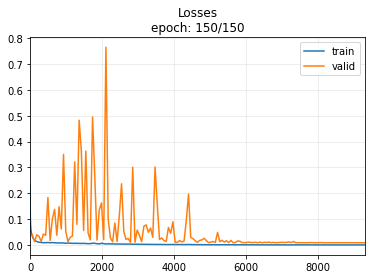

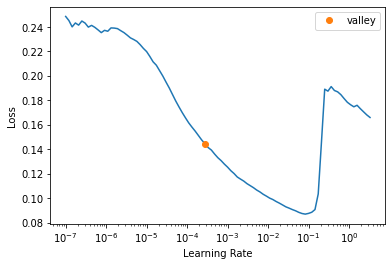

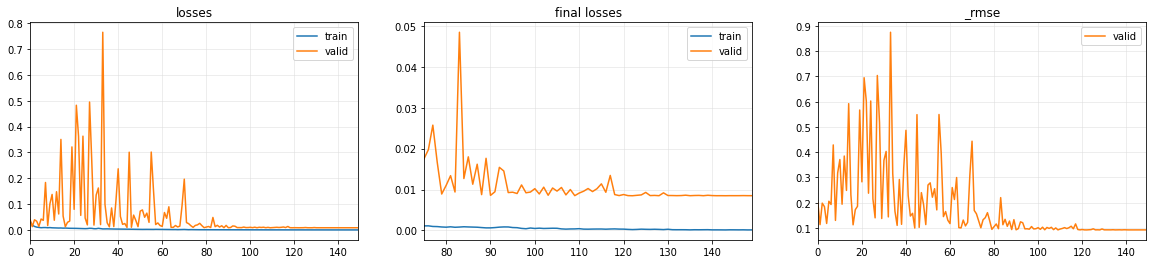

 21%|██        | 5/24 [18:23<1:27:52, 277.50s/it]

TCN


epoch,train_loss,valid_loss,_rmse,time
0,0.456166,0.408083,0.638814,00:01
1,0.318219,0.154576,0.393162,00:01
2,0.140907,0.060031,0.245013,00:01
3,0.080598,0.056473,0.237641,00:01
4,0.062169,0.054228,0.232869,00:01
5,0.055203,0.051777,0.227545,00:01
6,0.051288,0.048742,0.220776,00:01
7,0.048345,0.046190,0.214919,00:01
8,0.046675,0.044145,0.210107,00:01
9,0.044934,0.042874,0.207060,00:01


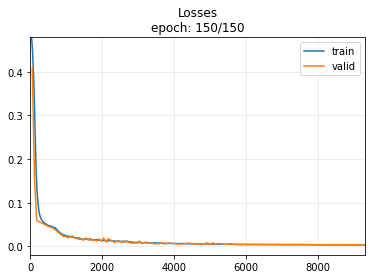

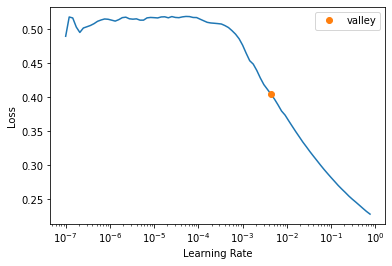

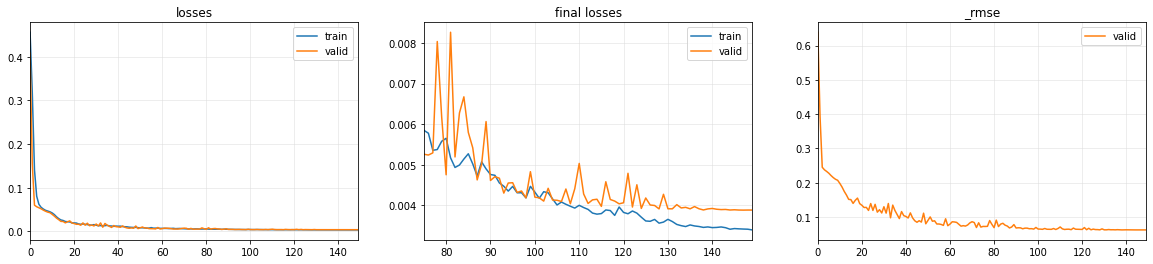

 25%|██▌       | 6/24 [22:31<1:20:11, 267.32s/it]

InceptionTime


epoch,train_loss,valid_loss,_rmse,time
0,0.049649,0.015614,0.124957,00:02
1,0.019803,0.020366,0.142711,00:02
2,0.011786,0.013680,0.116961,00:02
3,0.008858,0.013005,0.114038,00:02
4,0.008655,0.011892,0.109051,00:02
5,0.007564,0.064045,0.253071,00:02
6,0.007533,0.036933,0.192181,00:02
7,0.007297,0.022744,0.150812,00:02
8,0.007865,0.033194,0.182191,00:02
9,0.007608,0.020127,0.141868,00:02


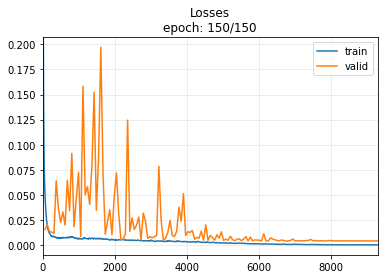

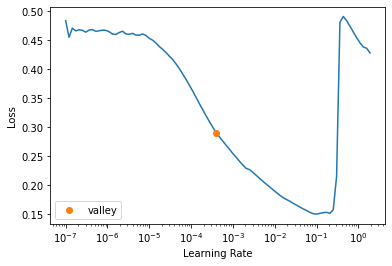

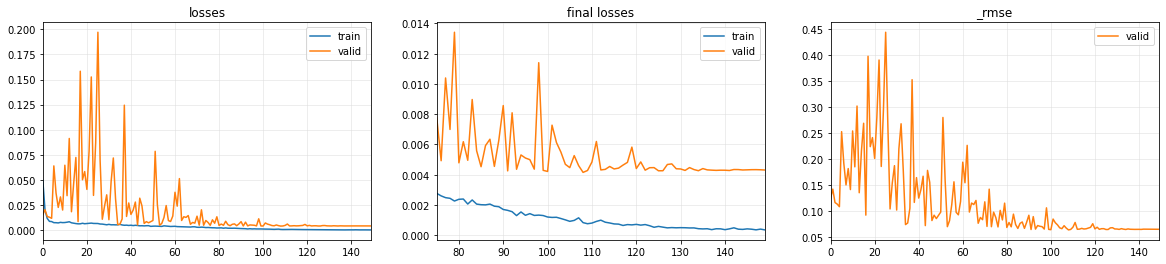

 29%|██▉       | 7/24 [29:42<1:30:55, 320.91s/it]

XceptionTime


epoch,train_loss,valid_loss,_rmse,time
0,0.048946,0.033722,0.183635,00:02
1,0.030945,0.025593,0.159978,00:02
2,0.022787,0.023461,0.153169,00:02
3,0.019305,0.019624,0.140087,00:02
4,0.017760,0.016906,0.130023,00:02
5,0.016069,0.013714,0.117106,00:02
6,0.015184,0.015689,0.125258,00:02
7,0.013730,0.012774,0.113022,00:02
8,0.013160,0.010770,0.103778,00:02
9,0.012738,0.010624,0.103074,00:02


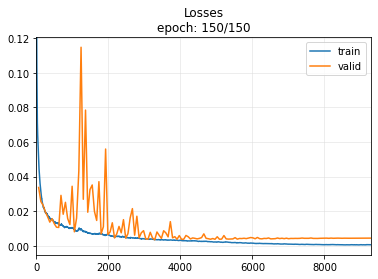

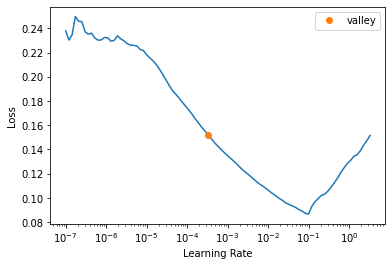

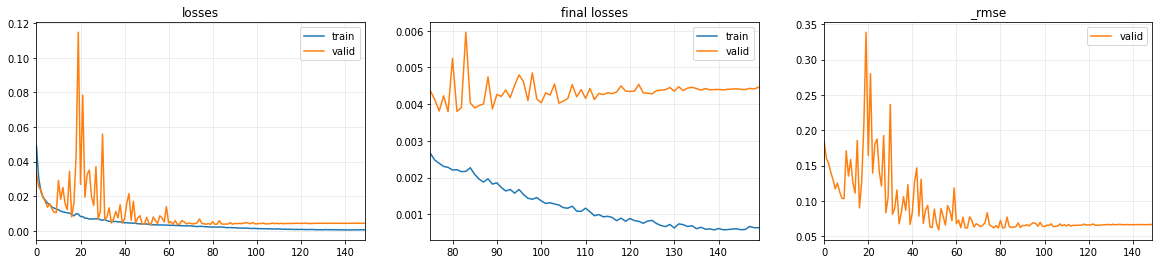

 33%|███▎      | 8/24 [36:22<1:32:14, 345.92s/it]

ResCNN


epoch,train_loss,valid_loss,_rmse,time
0,0.062574,0.021524,0.146709,00:00
1,0.028641,0.015909,0.126131,00:00
2,0.018534,0.013085,0.114389,00:00
3,0.014152,0.012884,0.113507,00:00
4,0.012288,0.010880,0.104307,00:00
5,0.010659,0.009183,0.095829,00:00
6,0.011296,0.025158,0.158612,00:00
7,0.009994,0.010720,0.103536,00:00
8,0.009412,0.007219,0.084967,00:00
9,0.009402,0.007495,0.086574,00:00


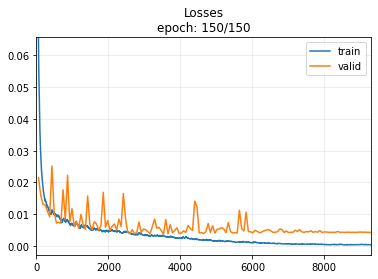

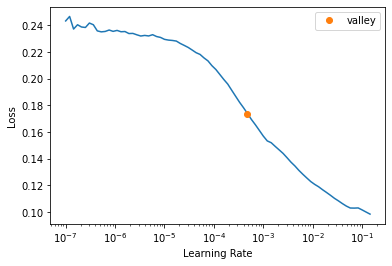

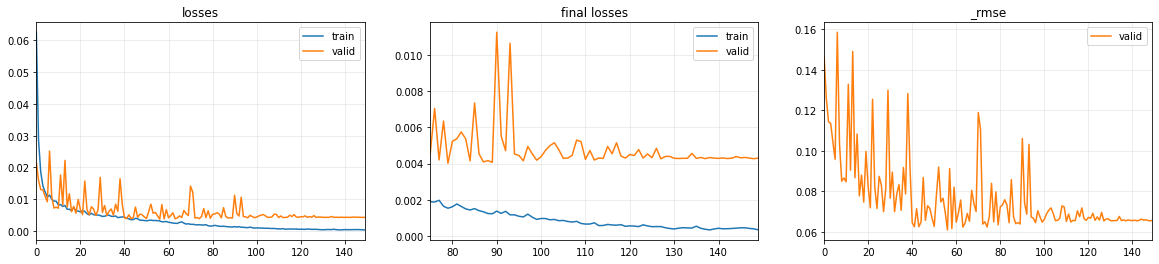

 38%|███▊      | 9/24 [39:28<1:14:00, 296.02s/it]

TST


epoch,train_loss,valid_loss,_rmse,time
0,0.096955,0.066237,0.257365,00:06
1,0.084032,0.056842,0.238416,00:06
2,0.073809,0.053221,0.230697,00:06
3,0.070394,0.047683,0.218364,00:06
4,0.069122,0.086765,0.294559,00:06
5,0.062998,0.055590,0.235775,00:06
6,0.067365,0.069930,0.264443,00:06
7,0.058206,0.055218,0.234985,00:06
8,0.054291,0.090342,0.300569,00:06
9,0.054080,0.054667,0.233809,00:06


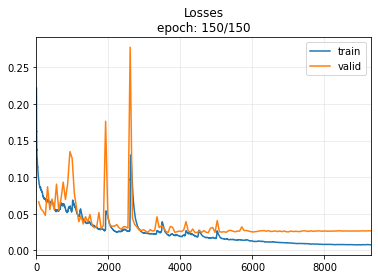

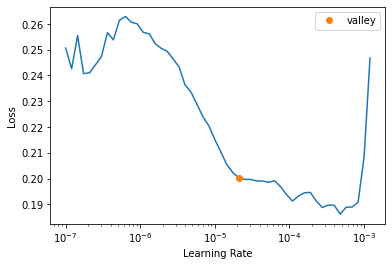

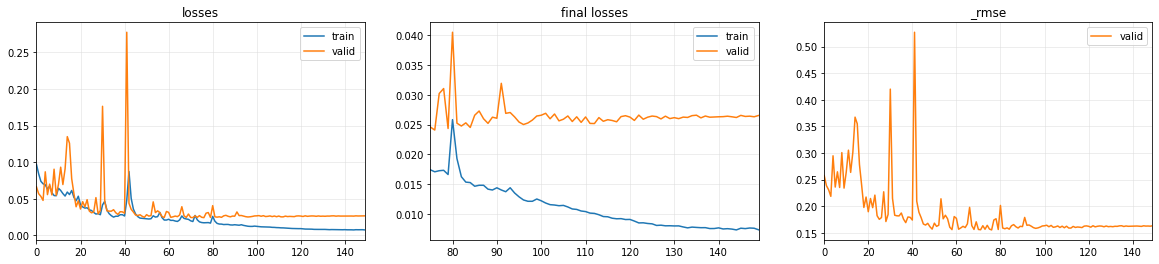

 42%|████▏     | 10/24 [56:58<2:03:24, 528.90s/it]

TSiT


epoch,train_loss,valid_loss,_rmse,time
0,0.103072,0.053596,0.231508,00:13
1,0.062768,0.048360,0.219910,00:13
2,0.050988,0.047325,0.217542,00:13
3,0.046463,0.043165,0.207761,00:13
4,0.042982,0.042298,0.205666,00:13
5,0.040754,0.042073,0.205117,00:13
6,0.039862,0.035942,0.189583,00:13
7,0.036252,0.033171,0.182129,00:13
8,0.035767,0.035807,0.189229,00:13
9,0.033365,0.032020,0.178942,00:13


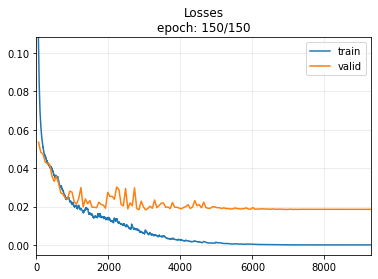

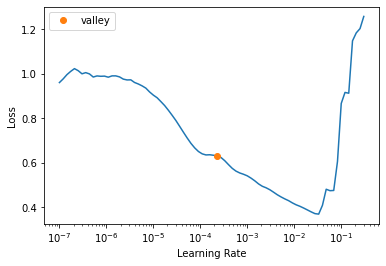

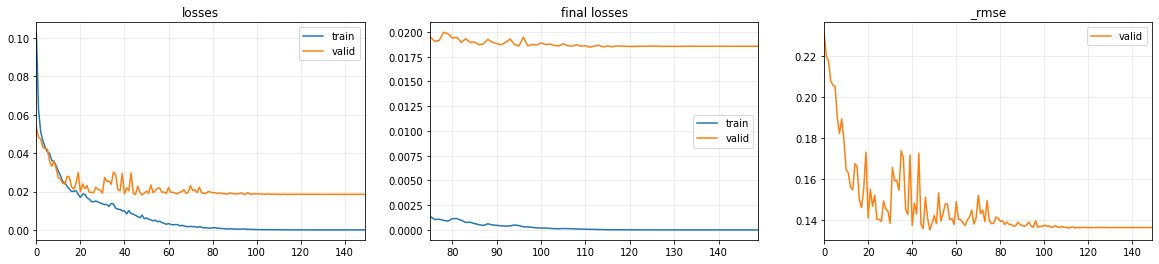

 46%|████▌     | 11/24 [1:31:04<3:35:10, 993.09s/it]

MiniRocket


epoch,train_loss,valid_loss,_rmse,time
0,0.259689,0.256882,0.506835,00:02
1,0.249248,0.244749,0.494721,00:02
2,0.238632,0.229570,0.479135,00:02
3,0.214295,0.187224,0.432694,00:02
4,0.166747,0.110759,0.332804,00:02
5,0.098713,0.051316,0.226530,00:02
6,0.051697,0.017970,0.134052,00:02
7,0.027600,0.013979,0.118232,00:02
8,0.016013,0.015258,0.123524,00:02
9,0.013360,0.014951,0.122273,00:02


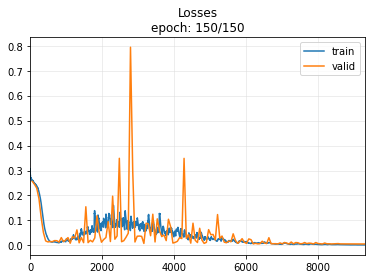

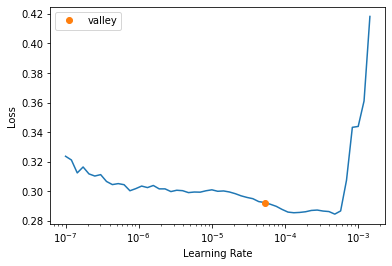

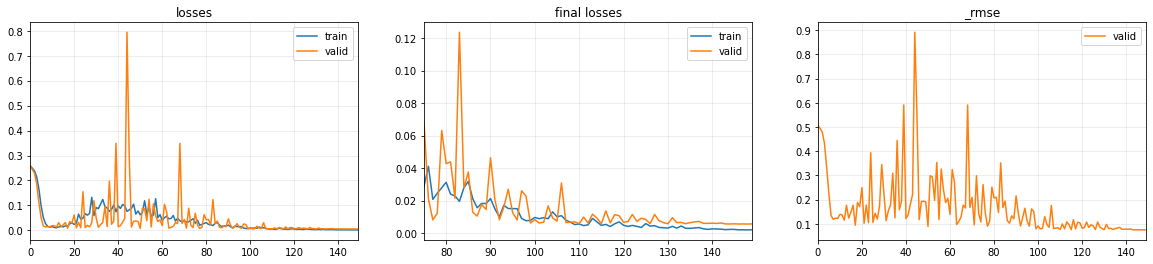

 50%|█████     | 12/24 [1:38:51<2:46:35, 832.97s/it]

XCM


epoch,train_loss,valid_loss,_rmse,time
0,0.042288,0.038221,0.195501,00:00
1,0.035831,0.034234,0.185023,00:00
2,0.030983,0.032180,0.179389,00:00
3,0.027702,0.024441,0.156336,00:00
4,0.024500,0.023232,0.152421,00:00
5,0.021925,0.019858,0.140919,00:00
6,0.019788,0.018850,0.137295,00:00
7,0.018476,0.019987,0.141376,00:00
8,0.016931,0.019321,0.139000,00:00
9,0.015966,0.014764,0.121507,00:00


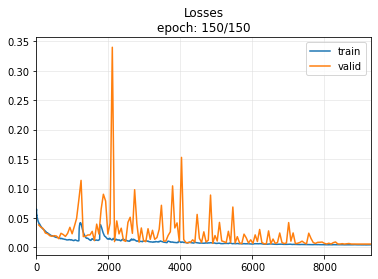

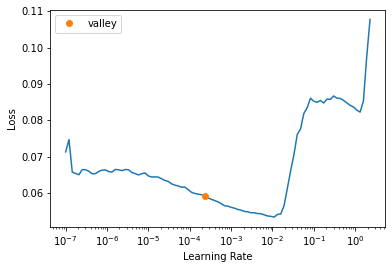

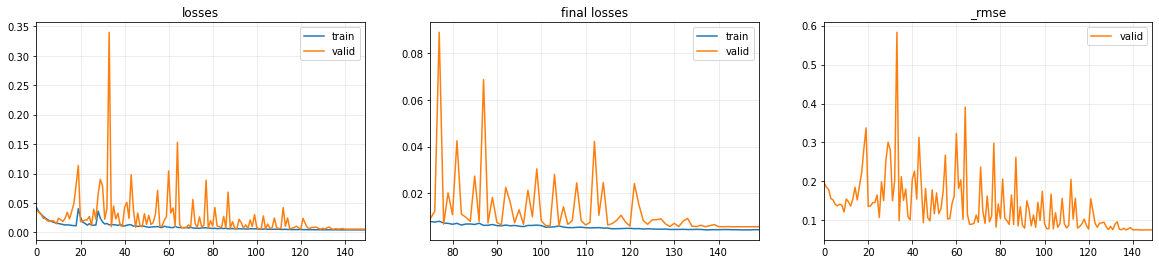

 54%|█████▍    | 13/24 [1:41:48<1:56:16, 634.27s/it]

gMLP


epoch,train_loss,valid_loss,_rmse,time
0,0.093632,0.053901,0.232167,00:07
1,0.061277,0.048157,0.219447,00:07
2,0.052763,0.047962,0.219001,00:07
3,0.050079,0.048023,0.219141,00:07
4,0.049048,0.049334,0.222114,00:08
5,0.047071,0.045671,0.213709,00:07
6,0.041786,0.034629,0.186089,00:07
7,0.034730,0.034806,0.186562,00:08
8,0.028276,0.023752,0.154117,00:08
9,0.023267,0.021817,0.147706,00:07


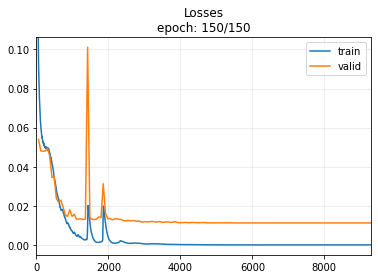

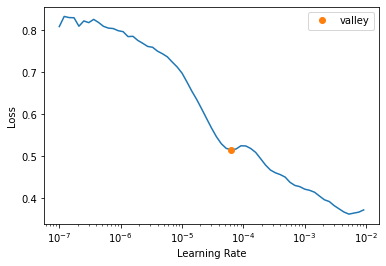

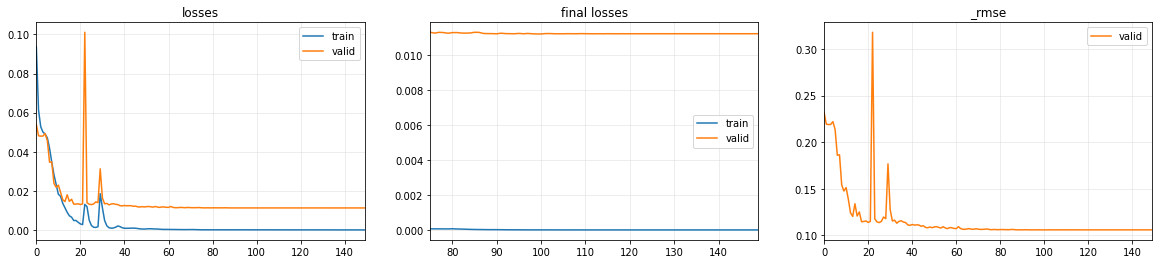

 58%|█████▊    | 14/24 [2:03:06<2:18:07, 828.71s/it]

TSSequencerPlus


epoch,train_loss,valid_loss,_rmse,time
0,0.051891,0.043665,0.208961,00:10
1,0.043411,0.040477,0.201188,00:10
2,0.038818,0.035906,0.189488,00:10
3,0.034593,0.033031,0.181744,00:11
4,0.032168,0.031033,0.176162,00:10
5,0.029396,0.030878,0.175723,00:10
6,0.027698,0.029682,0.172285,00:10
7,0.025647,0.026221,0.161929,00:10
8,0.024517,0.027442,0.165656,00:10
9,0.022304,0.025096,0.158418,00:10


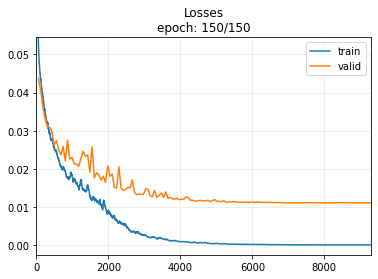

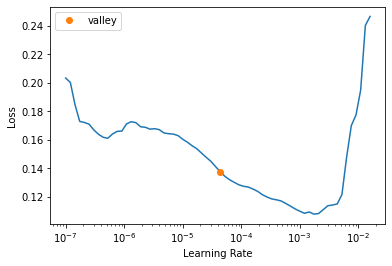

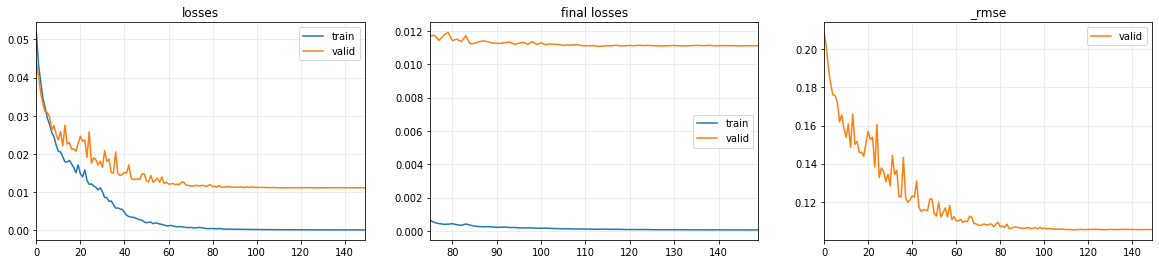

 62%|██████▎   | 15/24 [2:31:28<2:43:48, 1092.00s/it]

TransformerModel


epoch,train_loss,valid_loss,_rmse,time
0,0.131003,0.104962,0.323978,00:00
1,0.072337,0.102065,0.319476,00:00
2,0.056114,0.105167,0.324294,00:00
3,0.049925,0.109332,0.330653,00:00
4,0.047452,0.116474,0.341283,00:00
5,0.045845,0.114943,0.339033,00:00
6,0.044072,0.130753,0.361598,00:00
7,0.042502,0.141547,0.376227,00:00
8,0.041240,0.187065,0.432511,00:00
9,0.039744,0.179960,0.424217,00:00


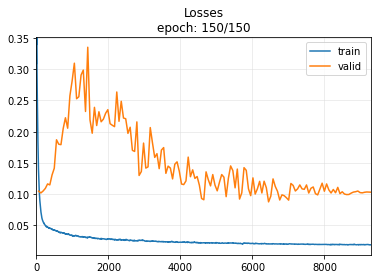

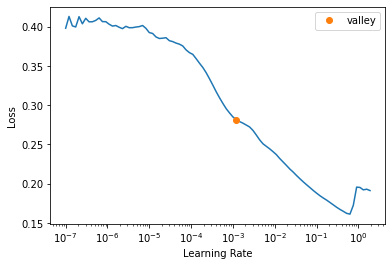

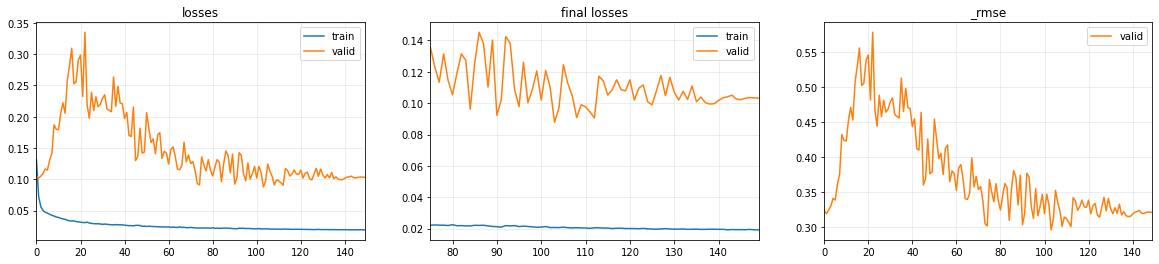

 67%|██████▋   | 16/24 [2:34:40<1:49:30, 821.25s/it] 

LSTMAttention


epoch,train_loss,valid_loss,_rmse,time
0,0.093194,0.108022,0.328667,00:07
1,0.069422,0.050006,0.223619,00:07
2,0.059699,0.041985,0.204904,00:07
3,0.055203,0.042008,0.204958,00:07
4,0.056304,0.037772,0.194351,00:07
5,0.047234,0.035847,0.189333,00:07
6,0.043859,0.034071,0.184584,00:07
7,0.045083,0.047706,0.218416,00:07
8,0.043725,0.035849,0.189338,00:07
9,0.047982,0.032956,0.181538,00:07


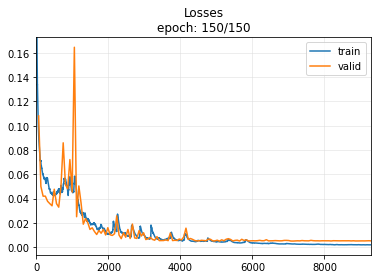

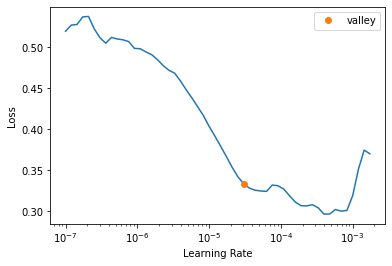

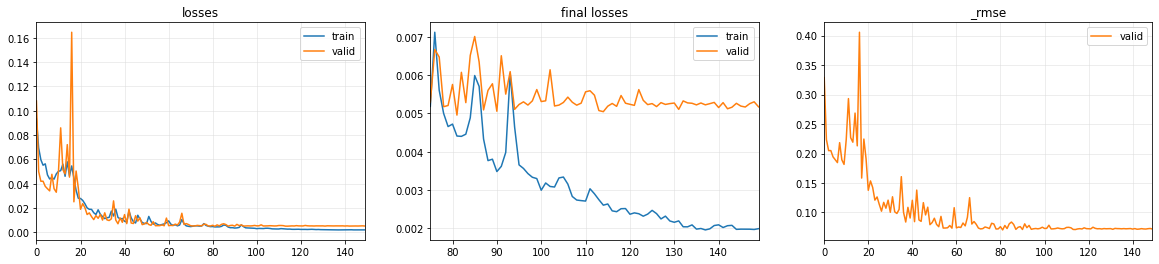

 71%|███████   | 17/24 [2:53:44<1:47:06, 918.03s/it]

GRUAttention


epoch,train_loss,valid_loss,_rmse,time
0,0.095425,0.104589,0.323402,00:06
1,0.069200,0.043647,0.208918,00:06
2,0.062111,0.047720,0.218448,00:06
3,0.056440,0.057584,0.239966,00:06
4,0.050243,0.044553,0.211076,00:06
5,0.046172,0.038405,0.195973,00:06
6,0.050183,0.050706,0.225180,00:06
7,0.050230,0.038116,0.195233,00:06
8,0.053420,0.053610,0.231538,00:06
9,0.045394,0.050275,0.224220,00:06


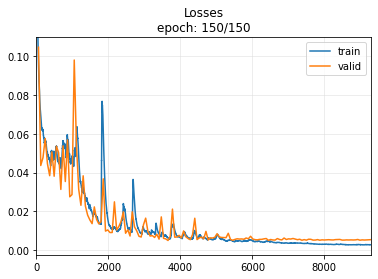

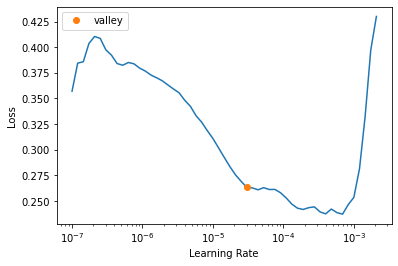

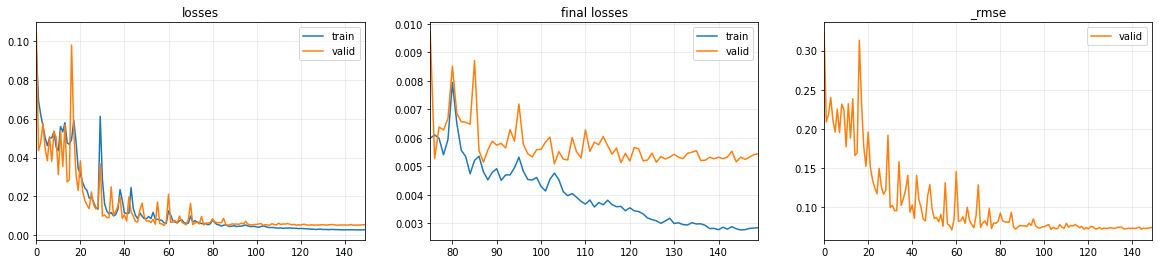

 75%|███████▌  | 18/24 [3:12:08<1:37:24, 974.15s/it]

RNN_FCN


epoch,train_loss,valid_loss,_rmse,time
0,0.443041,0.118901,0.344820,00:00
1,0.263461,0.059018,0.242937,00:00
2,0.161435,0.042012,0.204967,00:00
3,0.111473,0.028931,0.170091,00:00
4,0.084983,0.024233,0.155669,00:00
5,0.069008,0.018690,0.136713,00:00
6,0.055858,0.017052,0.130582,00:00
7,0.046111,0.016145,0.127061,00:00
8,0.037377,0.015967,0.126360,00:00
9,0.028733,0.011894,0.109061,00:00


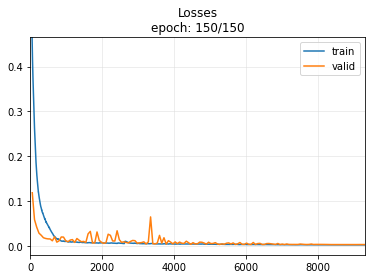

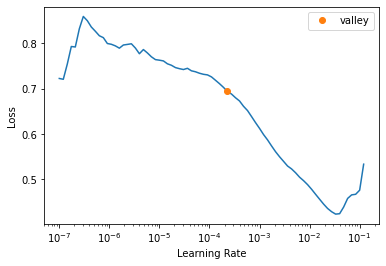

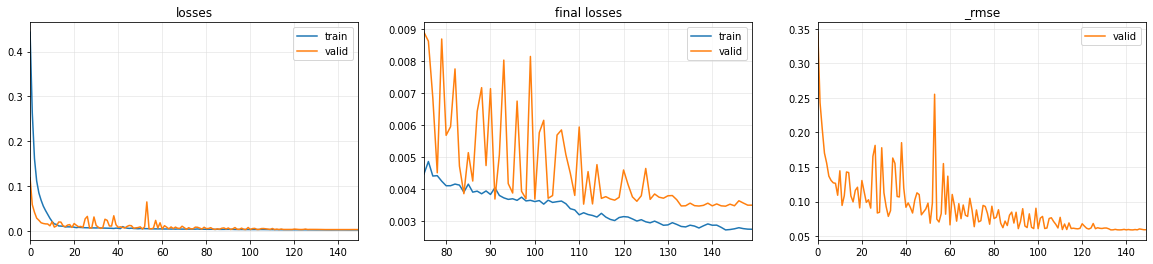

 79%|███████▉  | 19/24 [3:14:56<1:00:59, 731.87s/it]

MLSTM_FCN


epoch,train_loss,valid_loss,_rmse,time
0,0.151854,0.040116,0.200289,00:00
1,0.069187,0.025728,0.160400,00:00
2,0.044334,0.020563,0.143397,00:00
3,0.033483,0.019663,0.140225,00:00
4,0.027326,0.020823,0.144300,00:00
5,0.023218,0.017468,0.132167,00:00
6,0.019811,0.012810,0.113180,00:00
7,0.017122,0.010652,0.103211,00:00
8,0.015420,0.013580,0.116534,00:00
9,0.013490,0.009155,0.095684,00:00


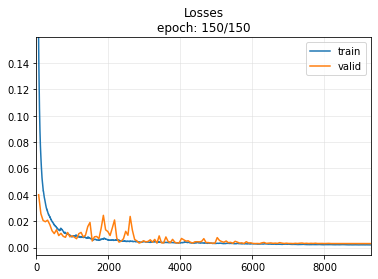

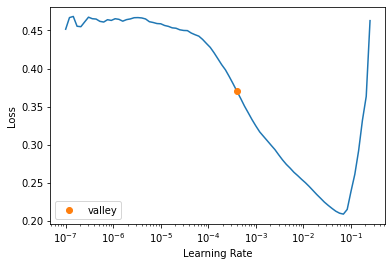

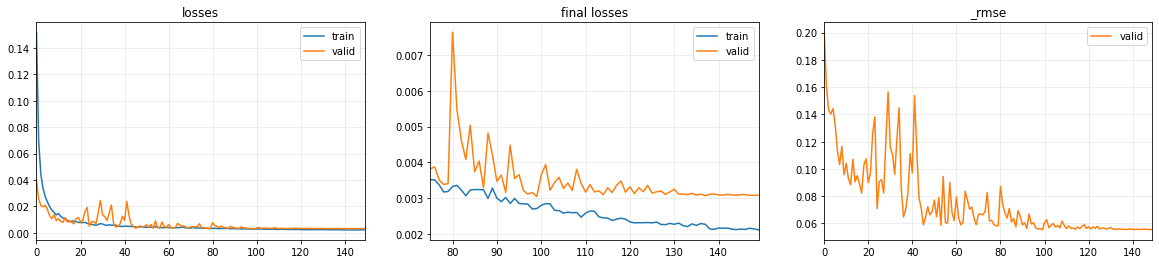

 83%|████████▎ | 20/24 [3:18:02<37:52, 568.18s/it]  

MRNN_FCN


epoch,train_loss,valid_loss,_rmse,time
0,0.315605,0.065124,0.255195,00:00
1,0.194440,0.037072,0.192540,00:00
2,0.134481,0.029415,0.171509,00:00
3,0.106683,0.023965,0.154808,00:00
4,0.083266,0.020486,0.143128,00:00
5,0.069790,0.023987,0.154878,00:00
6,0.059632,0.017914,0.133843,00:00
7,0.047347,0.014881,0.121987,00:00
8,0.038095,0.024375,0.156126,00:00
9,0.029660,0.013857,0.117715,00:00


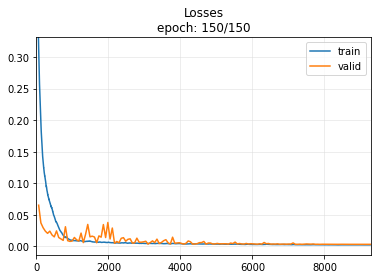

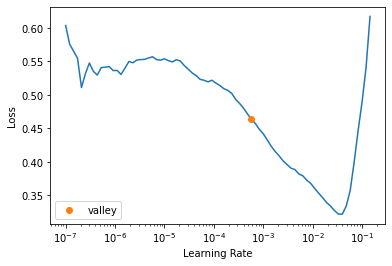

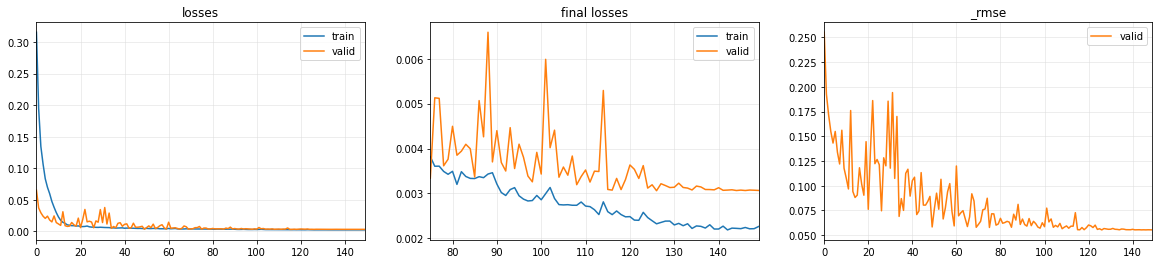

 88%|████████▊ | 21/24 [3:21:08<22:39, 453.20s/it]

GRU_FCN


epoch,train_loss,valid_loss,_rmse,time
0,0.117885,0.035630,0.188759,00:00
1,0.082042,0.026933,0.164112,00:00
2,0.061319,0.022149,0.148825,00:00
3,0.047288,0.018434,0.135773,00:00
4,0.037184,0.017071,0.130657,00:00
5,0.031011,0.019553,0.139833,00:00
6,0.025573,0.015630,0.125021,00:00
7,0.021916,0.011585,0.107634,00:00
8,0.018409,0.010171,0.100850,00:00
9,0.016378,0.015406,0.124120,00:00


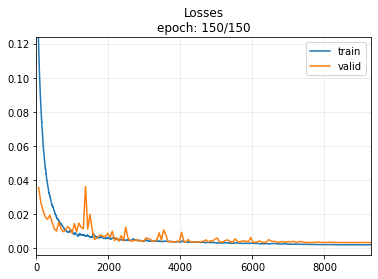

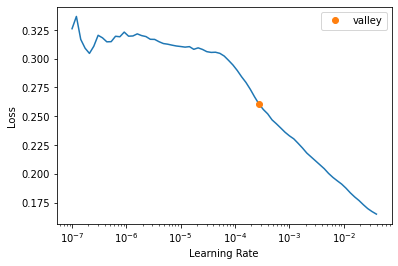

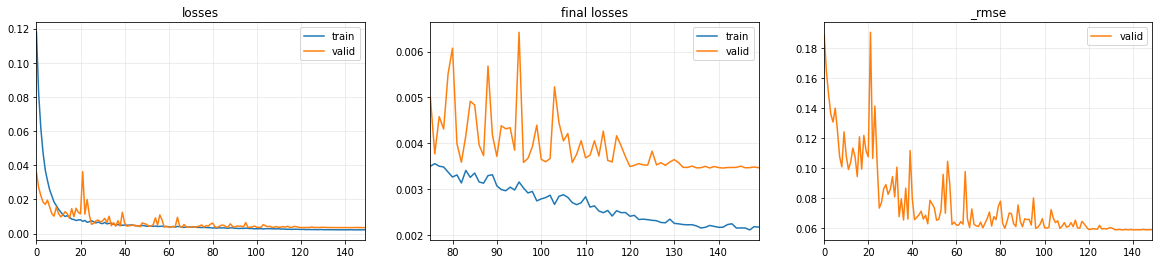

 92%|█████████▏| 22/24 [3:23:57<12:15, 367.92s/it]

LSTM_FCN


epoch,train_loss,valid_loss,_rmse,time
0,0.071914,0.029806,0.172645,00:00
1,0.043172,0.023317,0.152700,00:00
2,0.032518,0.018717,0.136811,00:00
3,0.026057,0.017468,0.132167,00:00
4,0.021249,0.013749,0.117256,00:00
5,0.018251,0.012675,0.112585,00:00
6,0.016142,0.014335,0.119731,00:00
7,0.014525,0.013611,0.116664,00:00
8,0.012819,0.013946,0.118095,00:00
9,0.011499,0.009489,0.097410,00:00


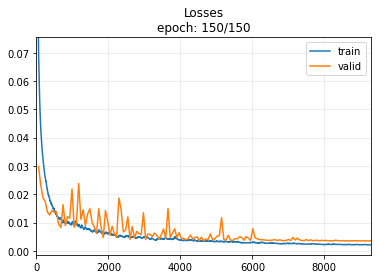

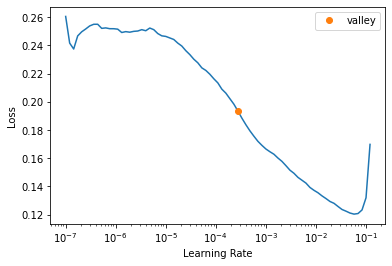

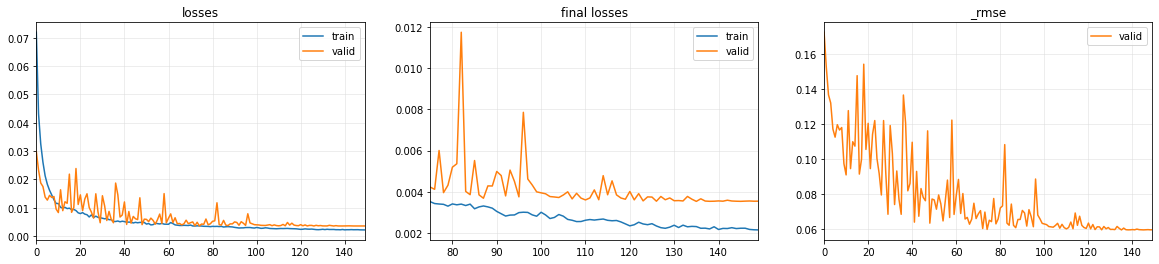

 96%|█████████▌| 23/24 [3:26:46<05:08, 308.46s/it]

TSTPlus


epoch,train_loss,valid_loss,_rmse,time
0,0.088530,0.063722,0.252433,00:07
1,0.061661,0.050602,0.224950,00:07
2,0.053775,0.048187,0.219515,00:07
3,0.049185,0.049298,0.222033,00:07
4,0.045147,0.046236,0.215025,00:07
5,0.042480,0.052837,0.229863,00:07
6,0.044251,0.045341,0.212935,00:07
7,0.044459,0.059188,0.243285,00:07
8,0.040972,0.047978,0.219040,00:07
9,0.039003,0.044212,0.210267,00:07


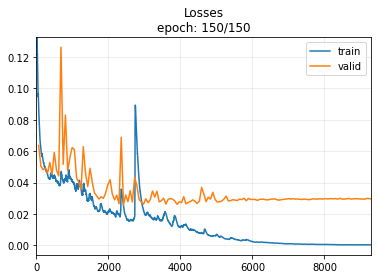

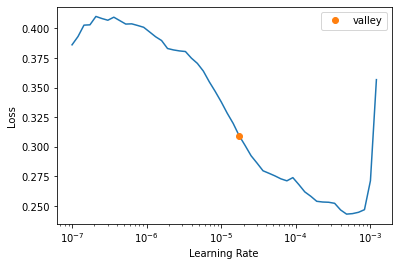

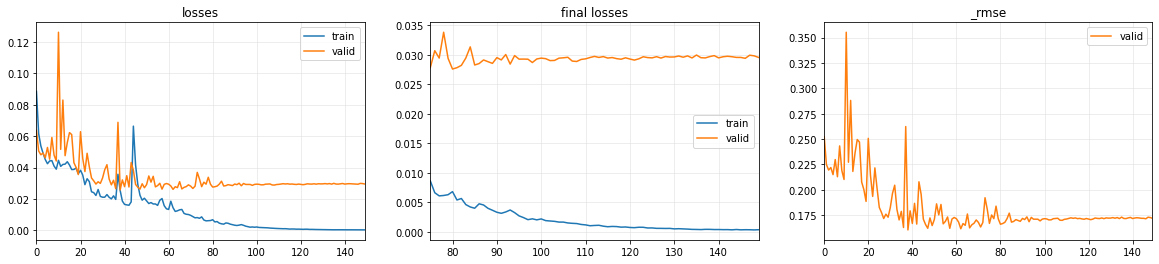

100%|██████████| 24/24 [3:46:28<00:00, 566.18s/it]


In [177]:
for arch in tqdm(archs):
    
    learn = ts_learner(dls, arch, metrics=rmse, cbs=ShowGraph())
    learn.lr_find()
    print(arch)
    learn.fit_one_cycle(150, learn.lr)
    learn.save_all(path='export', dls_fname='dls', model_fname=arch, learner_fname=arch)


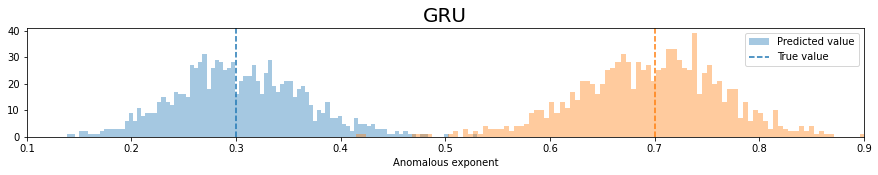

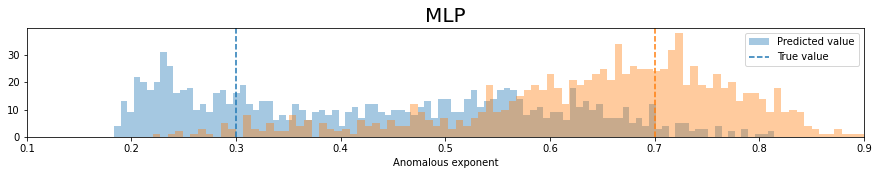

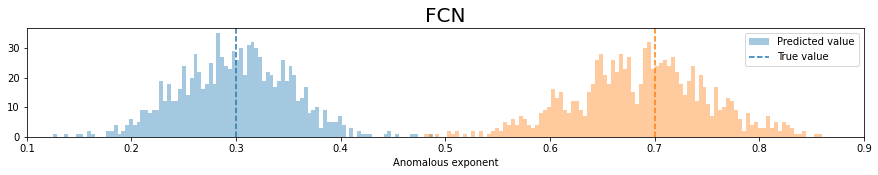

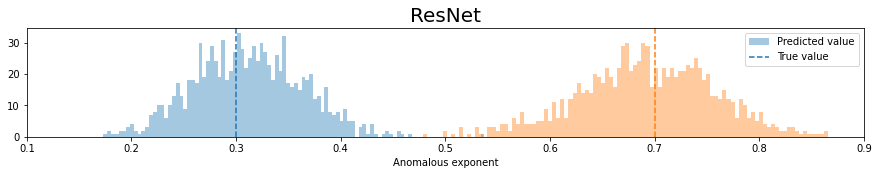

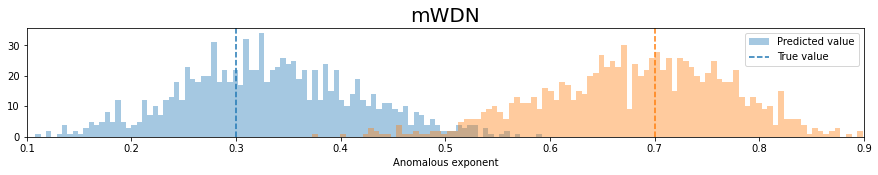

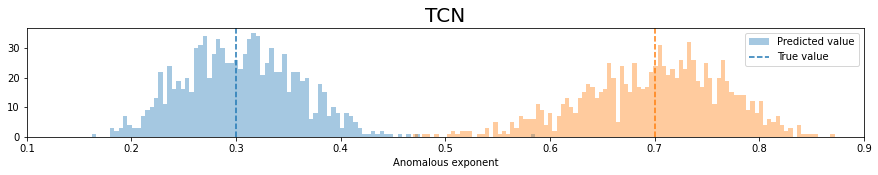

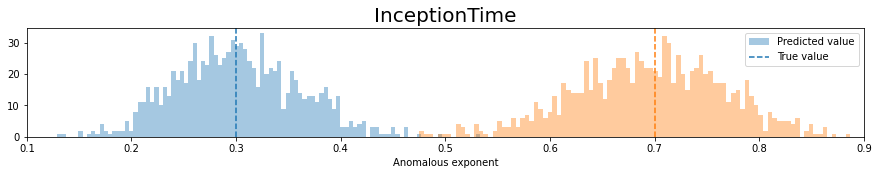

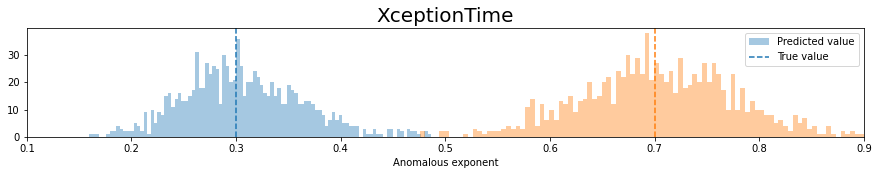

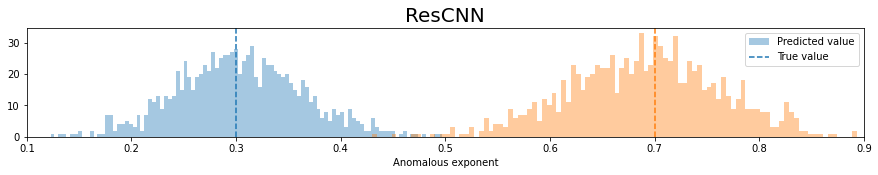

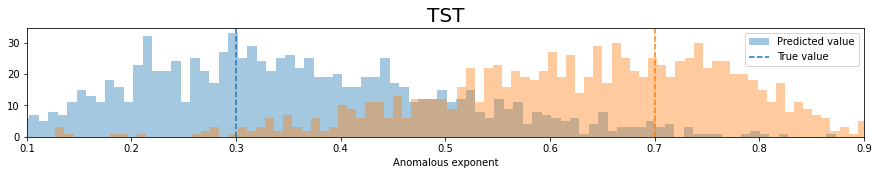

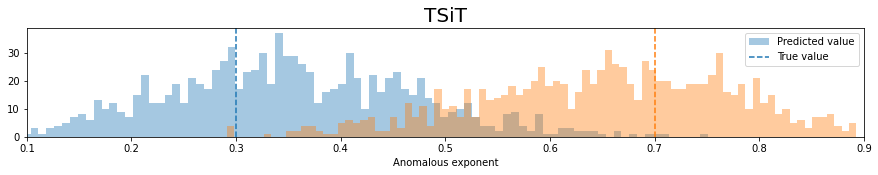

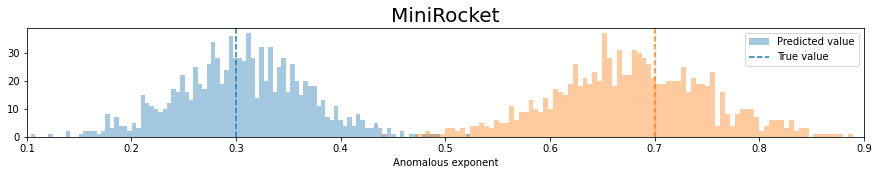

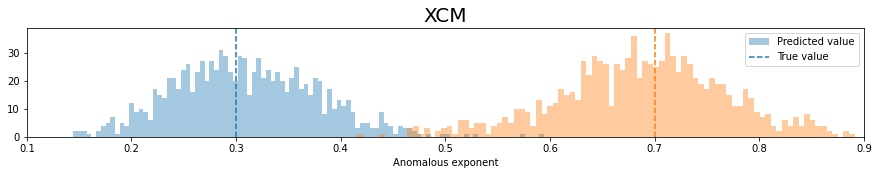

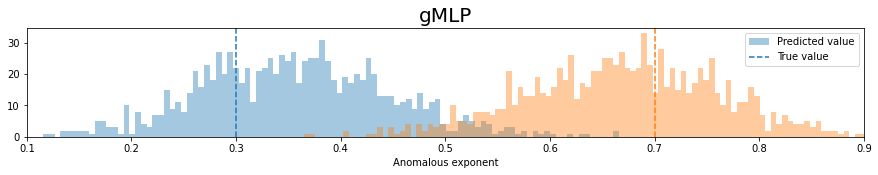

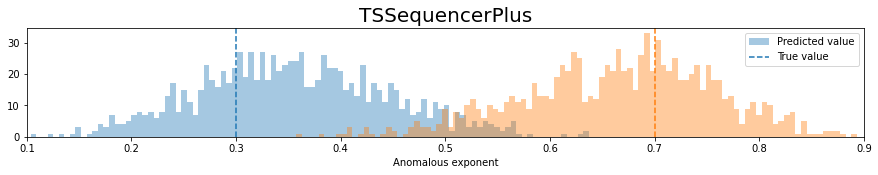

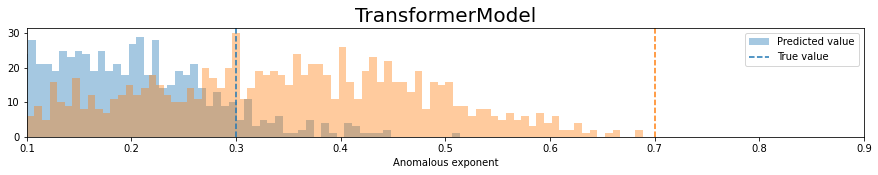

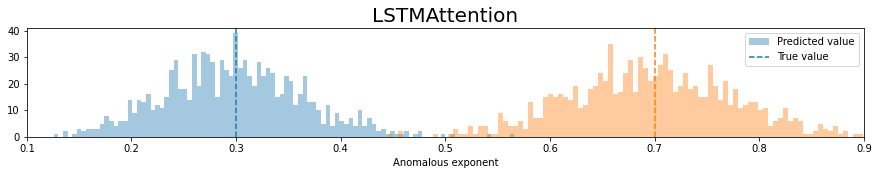

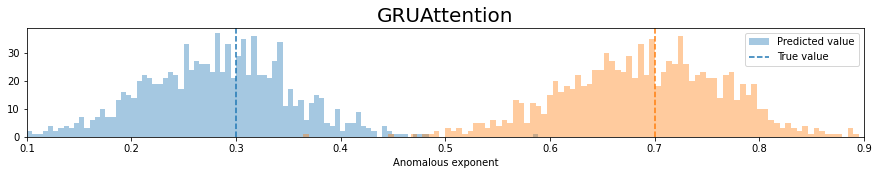

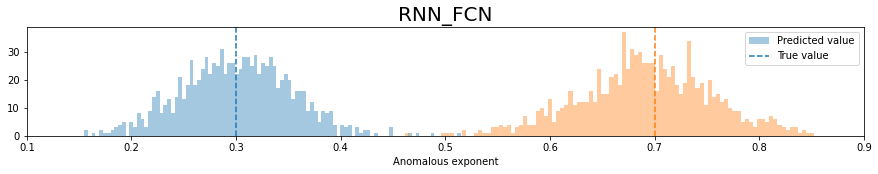

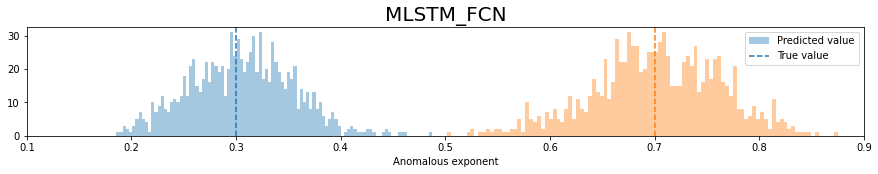

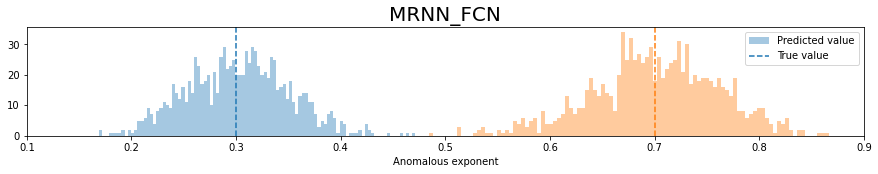

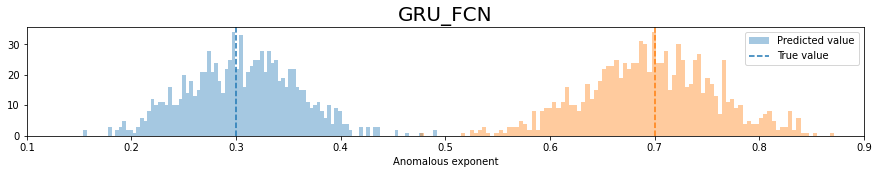

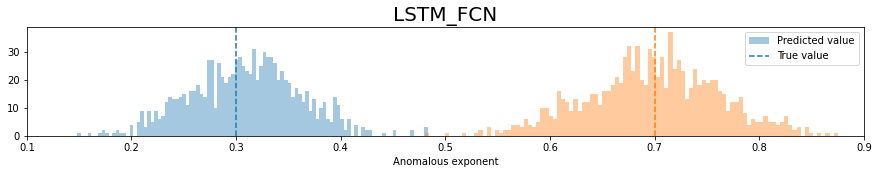

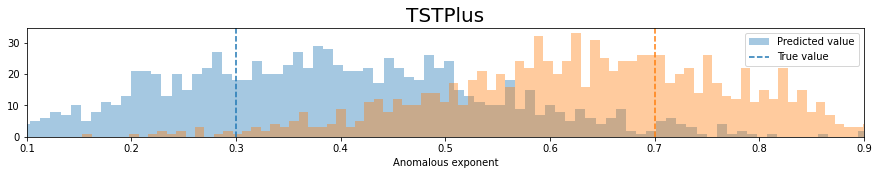

In [178]:
# fig, axes = plt.subplots(len(archs), 1, figsize=(15, 10))

for arch  in archs:
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 2))

    learn = load_learner_all(path='export', dls_fname='dls', model_fname=arch, learner_fname=arch)

    probas, _, preds = learn.get_X_preds(trajs_test)
    preds = np.array(preds)[:,0]

    for idx, u in enumerate(np.unique(labels_test)):

        mask = labels_test == u
        ax.hist(
            preds[mask],
            facecolor=f"C{idx}",
            bins=100,
            alpha=0.4,
            label="Predicted value" if idx == 0 else "",
        )
        ax.axvline(u, ls="--", c=f"C{idx}", label="True value" if idx == 0 else "")
    ax.legend()
    ax.set_xlabel("Anomalous exponent", fontsize=10)
    ax.set_title('{}'.format(arch), fontsize=20)
    ax.xaxis.set_tick_params(labelsize=10)
    ax.yaxis.set_tick_params(labelsize=10)
    ax.set_xlim([0.1, 0.9])
